# Feature Engineering, Dimensionality Reduction & Preprocessing

**Key Changes from EDA Master:**
1. **Disability Aggregate** - Replace binary `DIS` with severity score from 6 individual disability indicators
2. **Health Insurance Collapse** - Replace 3 insurance features with single binary (has/doesn't have)
3. **Race/Ethnicity Overhaul** - One-hot encode collapsed race categories + HISP ethnicity (no more label encoding)
4. **Education Tiers** - Replace ordinal SCHL with meaningful 5-level tier
5. **Dimensionality Reduction** - Elbow plot & feature importance to select optimal feature count
6. **Stratified K-Fold CV** - Cross-validation with resampling per fold
7. **Use Case Framing** - Recall-focused evaluation for social intervention pre-screening

**Data Source:** Raw `persons_master.csv` (to access all 274 columns including individual disability/race flags)

---
## Hypothetical Use Case

**Scenario:** A California state agency wants a pre-screening tool to identify households in poverty or at risk of falling below the poverty line, so they can proactively offer social services (housing assistance, job training, healthcare enrollment) before families slide further into poverty.

**Implication for Metrics:**
- **Prioritize Recall:** It's worse to miss a family that needs help (false negative) than to flag one that doesn't (false positive)
- **Primary Metric:** Recall for At-Risk class 
- **Secondary Metric:** F1 Score (balances precision and recall for imbalanced data)
- **Minimum Bar:** Must outperform a 50/50 coin toss (i.e., better than random)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_recall_curve, balanced_accuracy_score, ConfusionMatrixDisplay,
    recall_score
)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import xgboost as xgb
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
print('Libraries loaded.')
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from collections import Counter

Libraries loaded.


---
## 1: Load Raw Data & Recreate Base Variables

In [2]:
# Load raw master dataset (all 274 columns)
df_raw = pd.read_csv('../1_Raw_Data/data_persons_ca_1yr/persons_master.csv')
print(f'Raw data shape: {df_raw.shape}')
print(f'Years present: {sorted(df_raw["year"].unique())}')
print(f'Age range: {df_raw["AGEP"].min()} - {df_raw["AGEP"].max()}')

Raw data shape: (1842394, 275)
Years present: [np.int64(2018), np.int64(2019), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Age range: 19 - 94


In [3]:
# Filter to adults only (age > 18) — consistent with previous notebooks
df = df_raw[df_raw['AGEP'] > 18].copy()
print(f'Adults only: {df.shape}')

Adults only: (1842394, 275)


In [4]:
# Recreate poverty_risk_score (same logic as EDA)
def categorize_poverty_score(val):
    if pd.isna(val): return None
    if val <= 50: return 3      # Deep Poverty
    if val <= 100: return 2     # Poverty
    if val <= 200: return 1     # Near Poverty
    return 0                    # Stable

df['poverty_risk_score'] = df['POVPIP'].apply(categorize_poverty_score)

# Drop rows with no poverty score
df = df.dropna(subset=['poverty_risk_score'])
df['poverty_risk_score'] = df['poverty_risk_score'].astype(int)

# Binary target: Stable (0) vs At-Risk (1)
df['binary_target'] = (df['poverty_risk_score'] > 0).astype(int)

print('Target distribution (4-class):')
print(df['poverty_risk_score'].value_counts().sort_index())
print(f'\nBinary target distribution:')
print(df['binary_target'].value_counts())

Target distribution (4-class):
poverty_risk_score
0    1348539
1     235039
2      94529
3      96030
Name: count, dtype: int64

Binary target distribution:
binary_target
0    1348539
1     425598
Name: count, dtype: int64


In [5]:
# Recreate CA_Region (same logic as EDA)
def map_puma_to_region(puma):
    if pd.isna(puma): return 'Unknown'
    p = int(puma)
    if p < 1500: return 'Northern CA/Sierras'
    if 1500 <= p < 3000: return 'Bay Area'
    if 3000 <= p < 5000: return 'Central Valley'
    if 5000 <= p < 7000: return 'Central Coast'
    if 7000 <= p < 9000: return 'Los Angeles'
    if 9000 <= p < 10000: return 'Inland Empire'
    if p >= 10000: return 'San Diego/Border'
    return 'Unknown'

df['CA_Region'] = df['PUMA'].apply(map_puma_to_region)
print('Region distribution:')
print(df['CA_Region'].value_counts())

Region distribution:
CA_Region
Central Valley         510957
Los Angeles            488297
Central Coast          373489
Northern CA/Sierras    155818
Bay Area               102561
San Diego/Border        77098
Inland Empire           65917
Name: count, dtype: int64


---
## 2: Feature Engineering

### 2a. Disability Aggregate

**Previous approach:** Binary `DIS` (has disability vs. doesn't)  
**New approach:** Sum of 6 individual disability indicators → severity score (0-6)

Available ACS disability fields:
- `DEAR` - Hearing difficulty (1=Yes, 2=No)
- `DEYE` - Vision difficulty (1=Yes, 2=No)
- `DPHY` - Ambulatory difficulty (1=Yes, 2=No, 0=N/A under 5)
- `DREM` - Cognitive difficulty (1=Yes, 2=No, 0=N/A under 5)
- `DDRS` - Self-care difficulty (1=Yes, 2=No, 0=N/A under 5)
- `DOUT` - Independent living difficulty (1=Yes, 2=No, 0=N/A under 15)

In [6]:
# Create disability severity score (0-6)
# counts how many co-occurring disabilities someone has. A score of 3 just means "has 3 different disabilities." So the model learns that more comorbidities = higher poverty risk
disability_cols = ['DEAR', 'DEYE', 'DPHY', 'DREM', 'DDRS', 'DOUT']

# Check raw values
for col in disability_cols:
    print(f'{col}: {df[col].value_counts().sort_index().to_dict()}')

DEAR: {1: 76527, 2: 1697610}
DEYE: {1: 46762, 2: 1727375}
DPHY: {1.0: 137421, 2.0: 1636716}
DREM: {1.0: 93766, 2.0: 1680371}
DDRS: {1.0: 59726, 2.0: 1714411}
DOUT: {1.0: 112975, 2.0: 1661162}


In [7]:
# Convert: 1=Yes (has difficulty) → 1, 2=No → 0, 0=N/A → 0
for col in disability_cols:
    df[f'{col}_binary'] = (df[col] == 1).astype(int)

# Sum into disability severity score
df['disability_score'] = df[[f'{c}_binary' for c in disability_cols]].sum(axis=1)

print('Disability severity score distribution:')
print(df['disability_score'].value_counts().sort_index())
print(f'\nCorrelation with poverty_risk_score: {df["disability_score"].corr(df["poverty_risk_score"]):.4f}')
print(f'Correlation with POVPIP: {df["disability_score"].corr(df["POVPIP"]):.4f}')

# Compare to original binary DIS
print(f'\nOriginal DIS correlation with POVPIP: {(df["DIS"] == 1).astype(int).corr(df["POVPIP"]):.4f}')

Disability severity score distribution:
disability_score
0    1511749
1     130064
2      56506
3      37024
4      25049
5       9637
6       4108
Name: count, dtype: int64

Correlation with poverty_risk_score: 0.1401
Correlation with POVPIP: -0.1574

Original DIS correlation with POVPIP: -0.1527


### 2b. Health Insurance Collapse

**Previous approach:** 3 features — `HICOV`, `PRIVCOV`, `PUBCOV` 
**New approach:** Single binary — has any insurance (1) vs. no insurance (0)

**Rationale:** In California, Medi-Cal qualification requires being at or below the poverty line. Keeping PRIVCOV/PUBCOV separately may introduce quasi-data-leakage since public insurance status is essentially a proxy for poverty status.

In [8]:
# Check original insurance values
# ACS: 1=Yes (has coverage), 2=No (no coverage)
print('HICOV (any insurance):', df['HICOV'].value_counts().sort_index().to_dict())
print('PRIVCOV (private):', df['PRIVCOV'].value_counts().sort_index().to_dict())
print('PUBCOV (public):', df['PUBCOV'].value_counts().sort_index().to_dict())

HICOV (any insurance): {1: 1659142, 2: 114995}
PRIVCOV (private): {1: 1187345, 2: 586792}
PUBCOV (public): {1: 722283, 2: 1051854}


In [9]:
# Collapse to single binary: has_insurance (1=has any, 0=uninsured)
# HICOV: 1=has coverage, 2=no coverage
df['has_insurance'] = (df['HICOV'] == 1).astype(int)

print('has_insurance distribution:')
print(df['has_insurance'].value_counts())
print(f'\nCorrelation with POVPIP: {df["has_insurance"].corr(df["POVPIP"]):.4f}')

# Compare correlations
print(f'\n--- Correlation comparison with POVPIP ---')
print(f'has_insurance (new):  {df["has_insurance"].corr(df["POVPIP"]):.4f}')
print(f'PRIVCOV (old):        {(df["PRIVCOV"] == 1).astype(int).corr(df["POVPIP"]):.4f}')
print(f'PUBCOV (old):         {(df["PUBCOV"] == 1).astype(int).corr(df["POVPIP"]):.4f}')
print(f'HICOV (old):          {(df["HICOV"] == 1).astype(int).corr(df["POVPIP"]):.4f}')

has_insurance distribution:
has_insurance
1    1659142
0     114995
Name: count, dtype: int64

Correlation with POVPIP: 0.1566

--- Correlation comparison with POVPIP ---
has_insurance (new):  0.1566
PRIVCOV (old):        0.4329
PUBCOV (old):         -0.2917
HICOV (old):          0.1566


### 2c. Race/Ethnicity Overhaul

**Previous approach:** `RAC1P` label-encoded (1-9 → 0-8 integer). This is **problematic** because the model treats higher numeric values as more influential.

**New approach:**
1. Collapse to 5 race categories: White, Black, Asian, Indigenous, Other
2. Add `HISP` as binary Latinx ethnicity indicator
3. One-hot encode the 5 race categories
4. Create **racial-ethnic aggregate** (sum of one-hot values → captures multiracial identities)

The raw data has individual race flags: `RACWHT`, `RACBLK`, `RACASN`, `RACAIAN`, `RACNH`, `RACPI`, `RACSOR` — these are already binary (0/1).

In [10]:
# Check individual race flags in raw data
race_binary_cols = ['RACWHT', 'RACBLK', 'RACASN', 'RACAIAN', 'RACNH', 'RACPI', 'RACSOR']
print('Individual race flag distributions:')
for col in race_binary_cols:
    print(f'  {col}: {df[col].value_counts().sort_index().to_dict()}')

# Check HISP (Latinx ethnicity)
print(f'\nHISP unique values: {df["HISP"].nunique()}')
print(f'HISP == 1 (Not Hispanic): {(df["HISP"] == 1).sum()}')
print(f'HISP > 1 (Hispanic/Latino): {(df["HISP"] > 1).sum()}')

Individual race flag distributions:
  RACWHT: {0: 691477, 1: 1082660}
  RACBLK: {0: 1678869, 1: 95268}
  RACASN: {0: 1424899, 1: 349238}
  RACAIAN: {0: 1720050, 1: 54087}
  RACNH: {0: 1770584, 1: 3553}
  RACPI: {0: 1765309, 1: 8828}
  RACSOR: {0: 1370646, 1: 403491}

HISP unique values: 24
HISP == 1 (Not Hispanic): 1199950
HISP > 1 (Hispanic/Latino): 574187


In [11]:
# Collapse to 5 race categories using raw binary flags
# White, Black, Asian, Indigenous (AIAN + NH + PI), Other (SOR)
df['race_white'] = df['RACWHT']
df['race_black'] = df['RACBLK']
df['race_asian'] = df['RACASN']
df['race_indigenous'] = ((df['RACAIAN'] == 1) | (df['RACNH'] == 1) | (df['RACPI'] == 1)).astype(int)
df['race_other'] = df['RACSOR']

# Binary Latinx ethnicity (HISP: 1=Not Hispanic, 2+=Hispanic/Latino)
df['is_latinx'] = (df['HISP'] > 1).astype(int)

# Racial-ethnic aggregate: sum of all race + ethnicity flags
# Captures multiracial identities (e.g., half Black + half White + Latinx = score of 3)
race_ohe_cols = ['race_white', 'race_black', 'race_asian', 'race_indigenous', 'race_other', 'is_latinx']
df['race_ethnic_aggregate'] = df[race_ohe_cols].sum(axis=1)

print('Race one-hot distribution:')
for col in race_ohe_cols:
    print(f'  {col}: {df[col].sum():,} ({df[col].mean()*100:.1f}%)')

print(f'\nRacial-ethnic aggregate distribution:')
print(df['race_ethnic_aggregate'].value_counts().sort_index())

Race one-hot distribution:
  race_white: 1,082,660 (61.0%)
  race_black: 95,268 (5.4%)
  race_asian: 349,238 (19.7%)
  race_indigenous: 65,843 (3.7%)
  race_other: 403,491 (22.7%)
  is_latinx: 574,187 (32.4%)

Racial-ethnic aggregate distribution:
race_ethnic_aggregate
1    1141930
2     477720
3     145465
4       8253
5        704
6         65
Name: count, dtype: int64


In [12]:
# Correlation of new race features with POVPIP
print('Correlation of race/ethnicity features with POVPIP:')
for col in race_ohe_cols + ['race_ethnic_aggregate']:
    corr = df[col].corr(df['POVPIP'])
    print(f'  {col}: {corr:.4f}')

print(f'\nOriginal RAC1P correlation: {df["RAC1P"].corr(df["POVPIP"]):.4f}')

Correlation of race/ethnicity features with POVPIP:
  race_white: 0.0951
  race_black: -0.0538
  race_asian: 0.0780
  race_indigenous: -0.0306
  race_other: -0.1713
  is_latinx: -0.2155
  race_ethnic_aggregate: -0.1697

Original RAC1P correlation: -0.1181


### 2d. Education Tiers

**Previous approach:** Raw `SCHL` kept as ordinal (1-24)  
**New approach:** 5-level education tier (0-4)

ACS SCHL codes:
- 1-15: No high school diploma
- 16-17: High school diploma / GED
- 18-20: Some college / Associate's
- 21: Bachelor's degree
- 22-24: Advanced degree (Master's, Professional, Doctorate)

In [13]:
# Create 5-level education tier (0-4)
def education_tier(schl):
    if pd.isna(schl) or schl <= 15: return 0  # No HS diploma (some high school)
    if schl <= 17: return 1                     # HS diploma / GED
    if schl <= 20: return 2                     # Some college / Associate's
    if schl == 21: return 3                     # Bachelor's degree
    return 4                                     # Advanced degree (Master's/Prof/Doctorate)

df['education_tier'] = df['SCHL'].apply(education_tier)

print('Education tier distribution:')
tier_labels = {0: 'No HS', 1: 'HS/GED', 2: 'Some College/Assoc', 3: "Bachelor's", 4: 'Advanced'}
for tier, label in tier_labels.items():
    count = (df['education_tier'] == tier).sum()
    print(f'  {tier} ({label}): {count:,} ({count/len(df)*100:.1f}%)')

print(f'\nCorrelation with POVPIP: {df["education_tier"].corr(df["POVPIP"]):.4f}')
print(f'Original SCHL correlation: {df["SCHL"].corr(df["POVPIP"]):.4f}')

Education tier distribution:
  0 (No HS): 239,371 (13.5%)
  1 (HS/GED): 357,677 (20.2%)
  2 (Some College/Assoc): 513,034 (28.9%)
  3 (Bachelor's): 405,764 (22.9%)
  4 (Advanced): 258,291 (14.6%)

Correlation with POVPIP: 0.3847
Original SCHL correlation: 0.3339


### 2e. Additional Cleanup

Clean up remaining features:
- Keep employment features (`ESR`, `WKHP`, `WKL`, `WRK`, `OCCP`)
- Keep demographics (`AGEP`, `CIT`, `MAR`, `MSP`, `NATIVITY`, `SEX`, `MIG`)
- Keep language features (`ENG`, `LANX`) — drop `LANP` (57% null, high cardinality)
- Keep geography (`PUMA`, `CA_Region`)
- Drop `POBP` (high cardinality place of birth — 200+ values)
- Drop `year` (proven no temporal drift — adds noise)

In [14]:
# Define new feature set
# Engineered features
engineered_features = [
    'disability_score',      # Replaces DIS (0-6 severity)
    'has_insurance',         # Replaces HICOV, PRIVCOV, PUBCOV
    'race_white',            # One-hot race (replaces RAC1P)
    'race_black',
    'race_asian',
    'race_indigenous',
    'race_other',
    'is_latinx',             # Separate ethnicity flag
    'race_ethnic_aggregate', # Captures multiracial identities
    'education_tier',        # Replaces SCHL (0-4)
]

# Kept original features (unchanged)
kept_features = [
    'AGEP',       # Age (numeric)
    'CIT',        # Citizenship status
    'ENG',        # English ability
    'LANX',       # Language other than English
    'MAR',        # Marital status
    'MIG',        # Mobility status
    'MSP',        # Married, spouse present
    'SEX',        # Sex
    'NATIVITY',   # Nativity
    'ESR',        # Employment status
    'OCCP',       # Occupation
    'WKHP',       # Hours worked per week (numeric)
    'WKL',        # When last worked
    'WRK',        # Worked last week
    'PUMA',       # Public use microdata area
    'CA_Region',  # California region
]

# Dropped (with reasons)
dropped_features = {
    'DIS':      'Replaced by disability_score (0-6)',
    'HICOV':    'Replaced by has_insurance (binary)',
    'PRIVCOV':  'Replaced by has_insurance (binary) — was 0.32 importance, possible quasi-leakage',
    'PUBCOV':   'Replaced by has_insurance (binary) — Medi-Cal requires poverty-level income',
    'RAC1P':    'Replaced by one-hot race columns — label encoding was methodologically wrong',
    'SCHL':     'Replaced by education_tier (0-4)',
    'LANP':     'Dropped — 57% null, high cardinality (200+ languages)',
    'POBP':     'Dropped — high cardinality (200+ places of birth)',
    'year':     'Dropped — no temporal drift detected in random vs temporal split analysis',
}

all_features = engineered_features + kept_features

print(f'Total features: {len(all_features)}')
print(f'  Engineered: {len(engineered_features)}')
print(f'  Kept original: {len(kept_features)}')
print(f'  Dropped: {len(dropped_features)}')
print(f'\nDropped features and reasons:')
for feat, reason in dropped_features.items():
    print(f'  {feat}: {reason}')

Total features: 26
  Engineered: 10
  Kept original: 16
  Dropped: 9

Dropped features and reasons:
  DIS: Replaced by disability_score (0-6)
  HICOV: Replaced by has_insurance (binary)
  PRIVCOV: Replaced by has_insurance (binary) — was 0.32 importance, possible quasi-leakage
  PUBCOV: Replaced by has_insurance (binary) — Medi-Cal requires poverty-level income
  RAC1P: Replaced by one-hot race columns — label encoding was methodologically wrong
  SCHL: Replaced by education_tier (0-4)
  LANP: Dropped — 57% null, high cardinality (200+ languages)
  POBP: Dropped — high cardinality (200+ places of birth)
  year: Dropped — no temporal drift detected in random vs temporal split analysis


---
## 3: Null Handling & Preprocessing

In [15]:
# Null analysis across engineered feature set
def analyze_nulls(df, name="Dataset"):
    null_counts = df.isnull().sum()
    null_pct = (null_counts / len(df) * 100).round(2)
    null_df = pd.DataFrame({
        'null_count': null_counts,
        'null_pct': null_pct
    })
    null_df = null_df[null_df['null_count'] > 0].sort_values('null_pct', ascending=False)
    print(f"=== {name} Null Analysis ===")
    print(null_df)
    return null_df

# Analyze nulls in the features we'll actually use
analyze_nulls(df[all_features], "Engineered Feature Set")

=== Engineered Feature Set Null Analysis ===
      null_count  null_pct
ENG      1018084     57.38
WKHP      624259     35.19
OCCP      456087     25.71
WRK       206698     11.65


,null_count,null_pct
ENG,1018084,57.38
WKHP,624259,35.19
OCCP,456087,25.71
WRK,206698,11.65


### Understanding Null Patterns

The nulls in this dataset are **NOT random** — they represent meaningful "Not Applicable" (N/A) cases per ACS PUMS documentation:

| Feature | Why Null | ACS Code Meaning |
|---------|----------|------------------|
| **ENG** | Person speaks only English at home (LANX=2) | Ability to speak English — N/A for English-only speakers |
| **LANP** | Person speaks only English at home (LANX=2) | Language spoken at home — N/A for English-only speakers |
| **WKHP** | Person didn't work (not in labor force) | Usual hours worked per week — N/A for non-workers |
| **OCCP** | Person is not employed | Occupation code — N/A for unemployed/NILF |
| **WRK** | Various reasons (age, GQ status) | Worked in past 12 months |

**Strategy:** Replace nulls with explicit ACS-compliant codes for interpretability.

In [16]:
# Verify null patterns match ACS documentation
print("ENG null when LANX==2 (English only):",
      df[df['LANX'] == 2]['ENG'].isnull().mean() * 100, "%")
print("ENG null when LANX==1 (Other language):",
      df[df['LANX'] == 1]['ENG'].isnull().mean() * 100, "%")
print("OCCP null when ESR in [3,6] (Not employed):",
      df[df['ESR'].isin([3, 6])]['OCCP'].isnull().mean() * 100, "%")

ENG null when LANX==2 (English only): 100.0 %
ENG null when LANX==1 (Other language): 0.0 %
OCCP null when ESR in [3,6] (Not employed): 64.49312558064557 %


In [17]:
# ACS-compliant null handling based on ACS PUMS documentation

# ENG: 0 = N/A for English-only speakers
df['ENG'] = df['ENG'].fillna(0)

# WKHP: 0 = did not work
df['WKHP'] = df['WKHP'].fillna(0)

# WRK: 0 = not reported / N/A
df['WRK'] = df['WRK'].fillna(0)

# OCCP: "NILF" for unemployed / not in labor force
df['OCCP'] = df['OCCP'].fillna('NILF')

# Check for remaining nulls in our feature set
feature_df = df[all_features + ['poverty_risk_score', 'binary_target', 'POVPIP']].copy()
null_counts = feature_df[all_features].isnull().sum()
null_counts = null_counts[null_counts > 0]
if len(null_counts) > 0:
    print('Remaining nulls:')
    print(null_counts)
else:
    print('No null values in feature set.')

No null values in feature set.


In [18]:
# Temporal train/test split (same as previous notebooks)
# Train: 2018-2023, Test: 2024
train_mask = df['year'] < 2024
test_mask = df['year'] == 2024

df_train = df[train_mask].copy()
df_test = df[test_mask].copy()

print(f'Train set: {len(df_train):,} rows (years {sorted(df_train["year"].unique())})')
print(f'Test set:  {len(df_test):,} rows (year {df_test["year"].unique()})')
print(f'\nTrain binary target: {df_train["binary_target"].value_counts().to_dict()}')
print(f'Test binary target:  {df_test["binary_target"].value_counts().to_dict()}')

Train set: 1,469,769 rows (years [np.int64(2018), np.int64(2019), np.int64(2021), np.int64(2022), np.int64(2023)])
Test set:  304,368 rows (year [2024])

Train binary target: {0: 1114746, 1: 355023}
Test binary target:  {0: 233793, 1: 70575}


In [19]:
# Identify categorical vs numeric features for encoding
numeric_features = ['AGEP', 'WKHP', 'disability_score', 'education_tier', 'race_ethnic_aggregate']
binary_features = ['has_insurance', 'race_white', 'race_black', 'race_asian',
                   'race_indigenous', 'race_other', 'is_latinx']
categorical_features = ['CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'MSP', 'SEX',
                        'NATIVITY', 'ESR', 'OCCP', 'WKL', 'WRK', 'PUMA', 'CA_Region']

print(f'Numeric features ({len(numeric_features)}): {numeric_features}')
print(f'Binary features ({len(binary_features)}):  {binary_features}')
print(f'Categorical features ({len(categorical_features)}): {categorical_features}')
print(f'Total: {len(numeric_features) + len(binary_features) + len(categorical_features)}')

Numeric features (5): ['AGEP', 'WKHP', 'disability_score', 'education_tier', 'race_ethnic_aggregate']
Binary features (7):  ['has_insurance', 'race_white', 'race_black', 'race_asian', 'race_indigenous', 'race_other', 'is_latinx']
Categorical features (14): ['CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'MSP', 'SEX', 'NATIVITY', 'ESR', 'OCCP', 'WKL', 'WRK', 'PUMA', 'CA_Region']
Total: 26


In [20]:
# Label encode categorical features (for tree-based models)
# Binary and numeric features stay as-is
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df_train[col] = df_train[col].astype(str)
    df_test[col] = df_test[col].astype(str)
    
    le.fit(df_train[col])
    df_train[col] = le.transform(df_train[col])
    
    # Handle unseen categories in test set
    df_test[col] = df_test[col].apply(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )
    label_encoders[col] = le

print(f'Label encoded {len(categorical_features)} categorical features.')
print(f'Train shape: {df_train[all_features].shape}')
print(f'Test shape:  {df_test[all_features].shape}')

Label encoded 14 categorical features.
Train shape: (1469769, 26)
Test shape:  (304368, 26)


In [21]:
# Prepare X, y
X_train = df_train[all_features].copy()
y_train = df_train['binary_target'].copy()

X_test = df_test[all_features].copy()
y_test = df_test['binary_target'].copy()

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test:  {X_test.shape}, y_test:  {y_test.shape}')
print(f'\ny_train distribution: {Counter(y_train)}')
print(f'y_test distribution:  {Counter(y_test)}')

X_train: (1469769, 26), y_train: (1469769,)
X_test:  (304368, 26), y_test:  (304368,)

y_train distribution: Counter({0: 1114746, 1: 355023})
y_test distribution:  Counter({0: 233793, 1: 70575})


---
## 4: Dimensionality Reduction

1. Use XGBoost feature importance to rank features
2. Use elbow method on K-Means to determine optimal feature clusters
3. Prune low-importance features

In [22]:
# Step 1: Quick XGBoost to get feature importance ranking
# Use undersampled data for speed
rus = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)
print(f'Undersampled training set: {Counter(y_train_us)}')

# Quick XGBoost for feature importance
quick_model = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=20
)

quick_model.fit(
    X_train_us, y_train_us,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Feature importance
importance = pd.Series(
    quick_model.feature_importances_,
    index=all_features
).sort_values(ascending=False)

print('\nFeature Importance Ranking:')
for i, (feat, imp) in enumerate(importance.items(), 1):
    print(f'  {i:2d}. {feat:25s} {imp:.4f}')

Undersampled training set: Counter({0: 355023, 1: 355023})

Feature Importance Ranking:
   1. education_tier            0.1825
   2. MSP                       0.1725
   3. WKHP                      0.1606
   4. ESR                       0.0711
   5. ENG                       0.0520
   6. CIT                       0.0415
   7. MAR                       0.0321
   8. MIG                       0.0302
   9. is_latinx                 0.0298
  10. has_insurance             0.0268
  11. AGEP                      0.0251
  12. OCCP                      0.0185
  13. SEX                       0.0183
  14. race_black                0.0164
  15. WRK                       0.0162
  16. CA_Region                 0.0153
  17. disability_score          0.0139
  18. LANX                      0.0128
  19. race_white                0.0101
  20. PUMA                      0.0100
  21. race_asian                0.0099
  22. race_ethnic_aggregate     0.0099
  23. NATIVITY                  0.0095
  24. WKL      

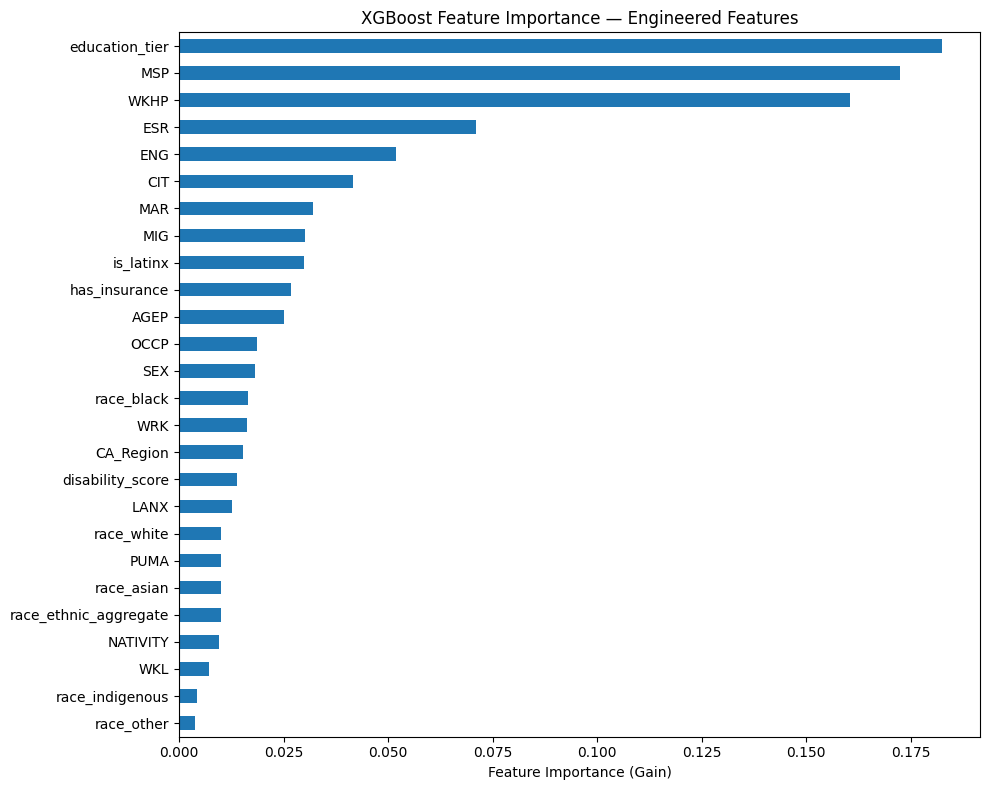

In [23]:
# Feature importance visualization
fig, ax = plt.subplots(figsize=(10, 8))
importance.plot(kind='barh', ax=ax)
ax.set_xlabel('Feature Importance (Gain)')
ax.set_title('XGBoost Feature Importance — Engineered Features')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../3_Data_Preprocessing/preprocessing_data/feature_importance_engineered.png', dpi=150, bbox_inches='tight')
plt.show()

In [24]:
# Step 2: Elbow plot — incremental feature addition by importance
# Train models with top-k features and measure performance
feature_ranking = importance.index.tolist()
results_by_k = []

for k in range(2, len(feature_ranking) + 1):
    top_k = feature_ranking[:k]
    
    X_tr_k = X_train_us[top_k]
    X_te_k = X_test[top_k]
    
    model_k = xgb.XGBClassifier(
        objective='binary:logistic',
        max_depth=6, learning_rate=0.1,
        n_estimators=200, subsample=0.8,
        colsample_bytree=0.8, random_state=42,
        eval_metric='logloss', early_stopping_rounds=20
    )
    model_k.fit(X_tr_k, y_train_us, eval_set=[(X_te_k, y_test)], verbose=False)
    
    y_pred_k = model_k.predict(X_te_k)
    f1_k = f1_score(y_test, y_pred_k, average='macro')
    bal_acc_k = balanced_accuracy_score(y_test, y_pred_k)
    
    results_by_k.append({'k': k, 'macro_f1': f1_k, 'balanced_acc': bal_acc_k, 'features': top_k})
    print(f'  k={k:2d}: Macro F1={f1_k:.4f}, Balanced Acc={bal_acc_k:.4f} | +{feature_ranking[k-1]}')

results_df = pd.DataFrame(results_by_k)

  k= 2: Macro F1=0.6254, Balanced Acc=0.6738 | +MSP
  k= 3: Macro F1=0.6531, Balanced Acc=0.7164 | +WKHP
  k= 4: Macro F1=0.6618, Balanced Acc=0.7199 | +ESR
  k= 5: Macro F1=0.6657, Balanced Acc=0.7275 | +ENG
  k= 6: Macro F1=0.6706, Balanced Acc=0.7312 | +CIT
  k= 7: Macro F1=0.6705, Balanced Acc=0.7310 | +MAR
  k= 8: Macro F1=0.6719, Balanced Acc=0.7319 | +MIG
  k= 9: Macro F1=0.6711, Balanced Acc=0.7323 | +is_latinx
  k=10: Macro F1=0.6710, Balanced Acc=0.7333 | +has_insurance
  k=11: Macro F1=0.6822, Balanced Acc=0.7388 | +AGEP
  k=12: Macro F1=0.6851, Balanced Acc=0.7443 | +OCCP
  k=13: Macro F1=0.6866, Balanced Acc=0.7464 | +SEX
  k=14: Macro F1=0.6863, Balanced Acc=0.7462 | +race_black
  k=15: Macro F1=0.6871, Balanced Acc=0.7467 | +WRK
  k=16: Macro F1=0.6887, Balanced Acc=0.7482 | +CA_Region
  k=17: Macro F1=0.6893, Balanced Acc=0.7488 | +disability_score
  k=18: Macro F1=0.6893, Balanced Acc=0.7487 | +LANX
  k=19: Macro F1=0.6889, Balanced Acc=0.7489 | +race_white
  k=20: Mac

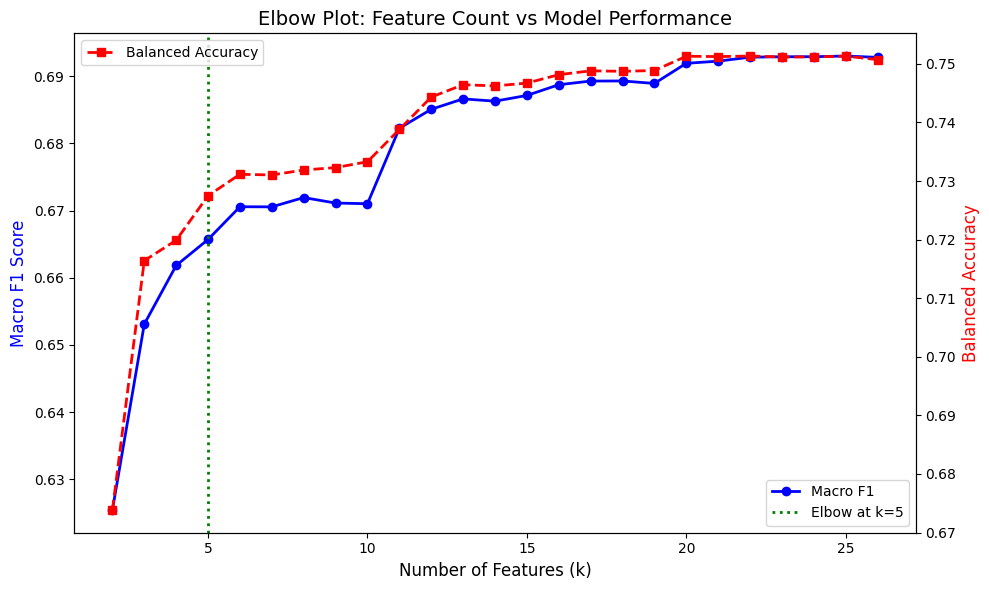


Elbow detected at k=5 features
Features to keep: ['education_tier', 'MSP', 'WKHP', 'ESR', 'ENG']


In [25]:
# Elbow plot
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(results_df['k'], results_df['macro_f1'], 'b-o', label='Macro F1', linewidth=2)
ax1.set_xlabel('Number of Features (k)', fontsize=12)
ax1.set_ylabel('Macro F1 Score', color='b', fontsize=12)

ax2 = ax1.twinx()
ax2.plot(results_df['k'], results_df['balanced_acc'], 'r--s', label='Balanced Accuracy', linewidth=2)
ax2.set_ylabel('Balanced Accuracy', color='r', fontsize=12)

# Mark the elbow (point of diminishing returns)
# Find where marginal gain drops below threshold
f1_gains = results_df['macro_f1'].diff()
elbow_idx = f1_gains[f1_gains < 0.005].first_valid_index()
if elbow_idx is not None:
    elbow_k = results_df.loc[elbow_idx, 'k']
    ax1.axvline(x=elbow_k, color='green', linestyle=':', linewidth=2, label=f'Elbow at k={elbow_k}')

ax1.legend(loc='lower right')
ax2.legend(loc='upper left')
plt.title('Elbow Plot: Feature Count vs Model Performance', fontsize=14)
plt.tight_layout()
plt.savefig('../3_Data_Preprocessing/preprocessing_data/elbow_plot_features.png', dpi=150, bbox_inches='tight')
plt.show()

if elbow_idx is not None:
    print(f'\nElbow detected at k={elbow_k} features')
    print(f'Features to keep: {feature_ranking[:elbow_k]}')
else:
    print('\nNo clear elbow detected — all features contribute meaningfully.')
    print('Consider keeping all features.')

  K= 2: Silhouette=0.1450, Inertia=1119159
  K= 3: Silhouette=0.1361, Inertia=1007155
  K= 4: Silhouette=0.1449, Inertia=927210
  K= 5: Silhouette=0.1499, Inertia=877423
  K= 6: Silhouette=0.1553, Inertia=833979
  K= 7: Silhouette=0.1568, Inertia=799797
  K= 8: Silhouette=0.1576, Inertia=769315
  K= 9: Silhouette=0.1469, Inertia=733648
  K=10: Silhouette=0.1435, Inertia=724824
  K=11: Silhouette=0.1612, Inertia=706496
  K=12: Silhouette=0.1509, Inertia=679105
  K=13: Silhouette=0.1482, Inertia=659941
  K=14: Silhouette=0.1458, Inertia=645380


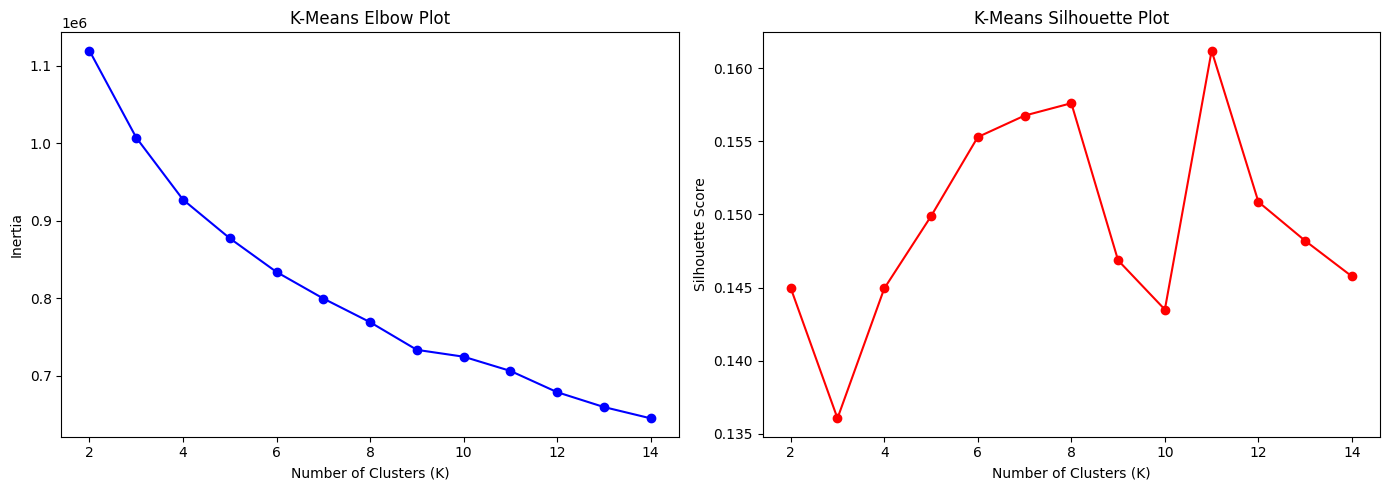

In [26]:
# Step 3: K-Means silhouette analysis on feature space
# Scale features for K-Means
scaler = StandardScaler()
# Use a sample for speed (K-Means on 1.4M rows is slow)
sample_idx = np.random.RandomState(42).choice(len(X_train_us), size=min(50000, len(X_train_us)), replace=False)
X_sample = scaler.fit_transform(X_train_us.iloc[sample_idx])

silhouette_scores = []
inertias = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=100)
    labels = kmeans.fit_predict(X_sample)
    sil = silhouette_score(X_sample, labels, sample_size=10000, random_state=42)
    silhouette_scores.append(sil)
    inertias.append(kmeans.inertia_)
    print(f'  K={k:2d}: Silhouette={sil:.4f}, Inertia={kmeans.inertia_:.0f}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(list(K_range), inertias, 'b-o')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('K-Means Elbow Plot')

ax2.plot(list(K_range), silhouette_scores, 'r-o')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('K-Means Silhouette Plot')

plt.tight_layout()
plt.savefig('../3_Data_Preprocessing/preprocessing_data/kmeans_elbow_silhouette.png', dpi=150, bbox_inches='tight')
plt.show()

In [27]:
# Decide on final feature set based on elbow analysis
# Use the best k from the elbow plot, or all features if no clear elbow
best_row = results_df.loc[results_df['macro_f1'].idxmax()]
best_k = int(best_row['k'])
best_f1 = best_row['macro_f1']

# Check if a smaller k achieves within 0.01 of the best
threshold = best_f1 - 0.01
parsimonious = results_df[results_df['macro_f1'] >= threshold].iloc[0]
optimal_k = int(parsimonious['k'])

optimal_features = feature_ranking[:optimal_k]

print(f'Best k={best_k} with Macro F1={best_f1:.4f}')
print(f'Most parsimonious k={optimal_k} (within 0.01 of best) with Macro F1={parsimonious["macro_f1"]:.4f}')

# Force-include all race/ethnicity variables (domain justification:
# poverty is structurally tied to race in the US — these features are
# essential for interpretability and equity auditing, even if the
# elbow plot did not rank them in the top-k by predictive importance)
race_vars = ['race_white', 'race_black', 'race_asian', 'race_indigenous',
             'race_other', 'is_latinx', 'race_ethnic_aggregate']

added_race = [r for r in race_vars if r not in optimal_features]
optimal_features = optimal_features + added_race

print(f'\nForce-included {len(added_race)} race/ethnicity variables: {added_race}')
print(f'\nFinal feature set ({len(optimal_features)} features):')
for i, f in enumerate(optimal_features, 1):
    marker = ' (race — domain-included)' if f in added_race else ''
    print(f'  {i}. {f}{marker}')

Best k=25 with Macro F1=0.6930
Most parsimonious k=12 (within 0.01 of best) with Macro F1=0.6851

Force-included 6 race/ethnicity variables: ['race_white', 'race_black', 'race_asian', 'race_indigenous', 'race_other', 'race_ethnic_aggregate']

Final feature set (18 features):
  1. education_tier
  2. MSP
  3. WKHP
  4. ESR
  5. ENG
  6. CIT
  7. MAR
  8. MIG
  9. is_latinx
  10. has_insurance
  11. AGEP
  12. OCCP
  13. race_white (race — domain-included)
  14. race_black (race — domain-included)
  15. race_asian (race — domain-included)
  16. race_indigenous (race — domain-included)
  17. race_other (race — domain-included)
  18. race_ethnic_aggregate (race — domain-included)


In [28]:
# Save preprocessed data for model notebook (4b_XGBoost_Model)
import json as _json

df_train.to_csv('preprocessing_data/train_engineered.csv', index=False)
df_test.to_csv('preprocessing_data/test_engineered.csv', index=False)

# Save feature lists and label encoder classes for reconstruction
metadata = {
    'all_features': all_features,
    'engineered_features': engineered_features,
    'kept_features': kept_features,
    'numeric_features': numeric_features,
    'binary_features': binary_features,
    'categorical_features': categorical_features,
    'label_encoder_classes': {col: le.classes_.tolist() for col, le in label_encoders.items()},
    'optimal_features': optimal_features
}
with open('preprocessing_data/feature_engineering_metadata.json', 'w') as f:
    _json.dump(metadata, f, indent=2)

print(f'Saved train_engineered.csv: {df_train.shape}')
print(f'Saved test_engineered.csv: {df_test.shape}')
print(f'Saved feature_engineering_metadata.json')

Saved train_engineered.csv: (1469769, 294)
Saved test_engineered.csv: (304368, 294)
Saved feature_engineering_metadata.json
